# Import

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F  # F.mse_loss
import torch.optim as optim
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from torch.utils.data import TensorDataset, DataLoader  # for batch and split Xtrain Ytrain dataset
import sys
import torchviz
import scipy
import scipy.ndimage as nd
from scipy.stats import norm
from scipy.optimize import minimize

from locale import format
from dataclasses import dataclass, MISSING

import seaborn as sns
import plotly.graph_objects as go


from scipy.interpolate import griddata
from scipy import special
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
# from scipy.sparse import identity
from icecream import ic  # for debugging. print variable name

## !!!!! To get the parameters
#from gdrive.MyDrive.Github.PredictiveCoding.main.Src.PC_param import default_parameters_network

#from PC_param import default_parameters_network
#import PC_param.ipynb
#from PC_Parameters import default_parameters_network

## !!!!! To get the parameters
import sys
#sys.path.insert(1, '/Users/knzga/Documents/folder/02_Computational Neuroscience Project/Programming/VScode/PredictiveCoding/main/Src/PC_param.ipynb')
sys.path.insert(1, '/main/CustomPackages/PC_param.py')

#https://github.com/Nozasp/PredictiveCoding/blob/main/
#main/Src

#C:\Users\knzga\Documents\02_Computational Neuroscience Project\Programming\VScode\PredictiveCoding\main\Src> 
#from PC_param import default_parameters_network #from PC_param 
from PC_param import default_parameters_network

pars = default_parameters_network()


{'ae': 18.26, 'be': -5.38, 'hme': 78.67, 'ai': 21.97, 'bi': -4.81, 'hmi': 125.62, 'taue': 0.005, 'taui': 0.005, 'tauNMDA': 0.1, 'tauGABA': 0.005, 'tauAMPA': 0.002, 'gamma': 0.641, 'sigma': 0.0007, 'I0e': 0.2346, 'I0i': 0.17, 'sigmaIn': 3, 'sigmaEI': 3, 'sigmaInh': [0.2, 3], 'I_ext': 0.0, 'c_dash': 90, 'mu0': 30, 'Jext': 0.01, 'I1': 0.57, 'I2': 0.029999999999999992, 'Jee': 0.2, 'Jie': 0.2, 'Jei': 1.4, 'Jii': 6.7, 'Jin': 0.008, 'Jiq': 0.85, 'Jes': 3.5, 'Jsi': 0.12, 'Jem': 2.2, 'I_noise': array([[-0.00088134],
       [ 0.00082885],
       [-0.0018112 ],
       [-0.00050257]]), 'T': 3, 'dt': 2e-05, 'r_init': 0.2, 'range_t': array([0.00000e+00, 2.00000e-05, 4.00000e-05, ..., 2.99994e+00,
       2.99996e+00, 2.99998e+00]), 'Lt': 150000, 'NumN': 20, 'f': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]), 'In0': 0, 'InMax': 50, 'Iq0': 0, 'IqMax': 10}


# Function

In [3]:

#### 2- Input/Output function

def plot_io(x, y, sign):
    if sign == "+":
        sign_name = 'Excitatory'
        label = "ae={0}, be={1}, hme={2}"
        a, b, hm = pars['ae'], pars['be'], pars['hme']
        color = "k"
    elif sign == "-":
        sign_name = 'Inhibitory'
        label = "ai={0}, bi={1}, hmi={2}"
        a, b, hm = pars['ai'], pars['bi'], pars['hmi']
        color = "r"

    plt.plot(x, y, color, label=label.format(a, b, hm))

    plt.xlabel("Input values - nA")
    plt.ylabel("Spike Frequency - Hz")
    plt.xlim([-0.01, 1])
    plt.title("Input-output function")
    # plt.title("{0} Input-output function".format(sign_name))
    plt.legend()


def plot_r(range_sim, r_e, r_i, param, xlim_ar=None):
    label_e = "Excitatoty  Jee={0}, Jei={1}"  # , I1={2}"
    label_i = "Inhibitory  Jii={0}, Jie={1}"  # , I2={2}"
    plt.plot(range_sim, r_e, "r", label=label_e.format(param.Jee, param.Jei))  # , param.I1 #, param.In
    plt.plot(range_sim, r_i, "orange", label=label_i.format(param.Jii, param.Jie))  # , round(param.I2, 2)))

    plt.xlabel("Time - ms")
    plt.ylabel("Spike Frequency - Hz")
    if xlim_ar != None:
        plt.xlim(xlim_ar)  # [0, .1]
    plt.title("Firing rate of the NMDA and GABA populations")
    plt.legend()


def plot_s(range_sim, S_e, S_i, param, xlim_ar=None):
    label_e = "Excitatoty  Jee={0}, Jei={1}"  # , I1={2}"
    label_i = "Inhibitory  Jii={0}, Jie={1}"  # , I2={2}"
    plt.plot(range_sim, S_e, "olive", label=label_e.format(param.Jee, param.Jei))  # , param.I1
    plt.plot(range_sim, S_i, "green", label=label_i.format(param.Jii, param.Jie))  # , round(param.I2, 2)
    if xlim_ar != None:
        plt.xlim(xlim_ar)
    plt.xlabel("Time - ms")
    plt.ylabel("Open channel")
    # plt.xlim([0, .1])
    plt.title("Average open channel for the NMDA and GABA populations")
    plt.legend()


# 2- Plot HeatMap of firing rate function
def HeatMap(rE, rI, J=None):
    if J == None:
        J = [.00989, 0.0081, .1, .87, .00081]  # J = dict(Jin=.008, Jee= .2, Jie=.2, Jei=1.4, Jii=6.7)
    if type(J) == dict:
        J = np.array(list(J.values()))

    rE_df = pd.DataFrame(rE.T)  # to get time vs pop
    rI_df = pd.DataFrame(rI.T)
    rE_df.index = rE_df.index + 1
    rI_df.index = rI_df.index + 1
    rE_df.index.name, rI_df.index.name = ["Excitatory Population", "Inhibitory Population"]
    rE_df.columns.name, rI_df.columns.name = ["Time ms", "Time ms"]
    # print(rE_df.loc[[10]])

    # set context for the upcoming plot
    sns.set_context("notebook", font_scale=.8, rc={"lines.linewidth": 2.5, 'font.family': 'Helvetica'})

    fig, (axA, axB) = plt.subplots(2, 1, figsize=(6, 6))

    sns.heatmap(rE_df, ax=axA, cmap="viridis")
    sns.heatmap(rI_df, ax=axB)
    axA.set_title(f"Firing rate in Hz of exc populations over time. Jie: {J[2]}, Jee: {J[1]}, Jin: {J[0]}",
                  fontdict={"fontsize": 10})
    axB.set_title(f"Firing rate in Hz of inh populations over time. Jei: {J[3]}, Jii: {J[4]}",
                  fontdict={"fontsize": 10})
    plt.tight_layout()

    plt.show()


# Filters gauss and Dog and LoG
def gaussian_filter(s, N):
    k = np.arange(1, N + 1)
    n = 1 / (np.sqrt(2 * np.pi) * N * s)
    gaussW = n * np.exp(-(k - k[:, np.newaxis]) ** 2 / (2 * s ** 2))
    gaussW2 = gaussW / (.009 ** 2 / np.max(gaussW))  # 1
    return gaussW2


def dog_filter(sOut, N):
    sIn = sOut / 30
    k = np.arange(1, N + 1)
    gaussIn = np.exp(-(k - k[:, np.newaxis]) ** 2 / (2 * sIn ** 2))
    gaussOut = np.exp(-(k - k[:, np.newaxis]) ** 2 / (2 * sOut ** 2))
    dog = gaussOut - gaussIn
    if np.max(dog) == 0 or None:
        print('zero max')
        dog = 0
    else:
        dog = dog / (.042 ** 2 / np.max(dog))  # .0088
    return dog


def LoG_filter(s, N):
    x_lap = np.eye(N)
    lapl_filter = nd.gaussian_laplace(x_lap, sigma=(s, s))
    return lapl_filter


def dLogGaus(s=.61, N=20):
    dig = LoG_filter(s, N) + gaussian_filter(.019 * s, N)
    return dig


"""### Differentiable function for back propagation

To avoid non-differentiable araising from discontinuity of the function, I "relax" (smoothen) the where() expression by using a sigmoid instead
*   with grad_fn:
*   if I get : > <SumBackward1 object at 0x7f79da0b9520> # differentiable
*   else I get none
"""


def relu_stim(x, stim):
    return torch.nn.functional.relu(1.0 - torch.abs(x - stim),
                                    inplace=False)  # inplace = False to avoid implace operation




def Dirac(A, N=pars["NumN"]):
    y = scipy.signal.unit_impulse(N, idx=(torch.max(torch.argmax(A))))  # , dtype= <class 'float'>)
    return torch.tensor(y)



"""### Try Normalization to "make it proba"
"""

"""
def make_it_proba(r_e):
    
    # print("should sum to 1:", torch.sum(prob_r, 1)) #to check that it worked
    baseline = 1 #1
    sum_r_e_and_baseline = torch.sum(r_e, 1).reshape(r_e.shape[0], 1) + baseline
    prob_r = torch.div(r_e + baseline, sum_r_e_and_baseline)

    #I add this because when re = 0 proba becomes one everywhere. Alright?
    for i in range(r_e.shape[0]):
        if torch.sum(r_e[i,:]) == 0:
            prob_r[i,:] = 0
        else:
            prob_r = prob_r


    return prob_r.reshape(r_e.shape[0], r_e.shape[1])  # log or not log?
""""""sum_r_e = torch.sum(r_e, 1).reshape(r_e.shape[0], 1)
    prob_r = torch.div(r_e, sum_r_e)
    print(prob_r.grad_fn)
    prob_r[prob_r != prob_r] = 0.05"""  # to replace nan to 1/20 - to sum to 1




def make_it_proba(r_e):

    eps = torch.FloatTensor([0.002])
    r_e_max = torch.max(r_e, eps.expand_as(r_e))
    threshold = 5# torch.FloatTensor([5]).expand_as(r_e[10,:])
    sum_r_e = torch.sum(r_e, 1).reshape(r_e.shape[0], 1)
 
    prob_r= 0.5 * (1 + torch.tanh(sum_r_e - threshold))*(r_e_max / sum_r_e) #r_e_max.sum())
    return prob_r #.reshape(r_e.shape[0], r_e.shape[1]) 

"""

def make_it_proba(r_e):

    baseline = 1 #1
    sum_r_e_and_baseline = torch.sum(r_e, 1).reshape(r_e.shape[0], 1) + baseline
    prob_r = torch.div(r_e + baseline, sum_r_e_and_baseline)

    #I add this because when re = 0 proba becomes one everywhere. Alright?
    for i in range(r_e.shape[0]):
        if torch.sum(r_e[i,:]) == 0:
            prob_r[i,:] = 0
        else:
            prob_r = prob_r
    return prob_r.reshape(r_e.shape[0], r_e.shape[1]) 

"""

def make_it_proba_1d(r_e):
    baseline = 1
    sum_r_e = torch.sum(r_e) + baseline
    prob_r = torch.div(r_e +baseline, sum_r_e)  # torch.transpose(r_e, dim0=0 ,dim1=1) poses a problem
    #prob_r[prob_r != prob_r] = 0.05  # to replace nan to 1/20 - to sum to 1
    print("should sum to 1:", torch.sum(prob_r)) #to check that it worked

    return prob_r


def log_proba(proba_r):
    return torch.log(proba_r)


"""### Try softmax to "make it proba"
"""


def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), axis=1, keepdims=True)

def softmax1D(x):
    return torch.exp(x) / torch.sum(torch.exp(x))

"""### Get the expected stimuli : matrix of 1 where stimuli 0 elsewhere"""


# find the stimuli for every X = stim dataset
# find the stimuli for every X = stim dataset
def get_stimuli_input(X_train_tensor):  # input of the shape Xtrain_tensor[5,:,:]
    Xargmax = torch.argmax(X_train_tensor, dim=1)
    Xmax = torch.max(Xargmax)
    return Xmax

def get_stimuli_input1D(X_train_tensor):  # input of the shape Xtrain_tensor[5,:,:]
    Xargmax = torch.argmax(X_train_tensor)#, dim=1)
    Xmax = torch.max(Xargmax)
    return Xmax


# replace where function by relu functio which is differentiable
def get_expected_Y_relu(X_train_tensor):
    x_t = torch.transpose(X_train_tensor, 0, 1)
    dirac_2d = torch.zeros(x_t.shape)
    stim = get_stimuli_input(
        X_train_tensor)  # input of the shape Xtrain_tensor[5,:,:] # here get_stimuli not differenciable

    for pop, t in enumerate(x_t):
        tpop = torch.tensor(pop)
        dirac_2d[pop, :] = torch.nn.functional.relu(1.0 - torch.abs(tpop - stim), inplace=False).requires_grad_(False)
    dirac_2d = torch.transpose(dirac_2d, 1, 0)
    return dirac_2d


def get_expected_Y_relu_1d_where(X_train_tensor):
    stim = get_stimuli_input1D(X_train_tensor)
    dirac_1d = torch.zeros(X_train_tensor.shape)
    # Calculate the difference between tpop and stim
    for pop in enumerate(X_train_tensor):
        dirac_1d[pop[0]] = torch.where(pop[0] == torch.tensor(stim), torch.tensor(1.0), torch.tensor(0.0)).requires_grad_(False)#true #not differenciable
    return dirac_1d



"""### Optimization function"""

#Make a function which save parameters of trained model and upload the new model with the updated parameters

def model_with_saved_trained_param(old_model, optimizer, Model):
    # or to save the parameters only
    torch.save(old_model.state_dict(),"Old_model_optimized_parameters.pth")
    torch.save(optimizer.state_dict(),"optimizer_optimized_parameters.pth")
    #load these parameters in a new model instance
    new_mymodel = Model()
    new_mymodel.load_state_dict(torch.load("Old_model_optimized_parameters.pth")) 
    optimizer.load_state_dict(torch.load('optimizer_optimized_parameters.pth'))

    #print(optimizer.param_groups[0]['params'])
    print("old model",old_model.Jee,"new model", new_mymodel.Jee)
    #print(optimizer.param_groups)
    #print(optimizer.state)
    return new_mymodel, optimizer




# function wich test the accuracy of a model with new parameters compared to expected results + loss values for every samples
def test_model(model, test_dataloader, loss_f):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for x_test, y_test in test_dataloader:
            # Calculate output
            Y_prediction, _, dredt, dridt = model(x_test[0])
            #Y_prediction_prob = make_it_proba(Y_prediction)

            # Calculate loss
            #loss = loss_f(Y_prediction_prob, y_test[0], dredt, dridt)
            loss = loss_f(Y_prediction, y_test[0], dredt, dridt)

            # Accuracy
            predictions = Y_prediction.detach().round() # rounds the predictions to the nearest integer (0 or 1), assuming they represent probabilities.
            #predictions = Y_prediction_prob.detach().round() # rounds the predictions to the nearest integer (0 or 1), assuming they represent probabilities.
            correct_predictions += (predictions == y_test[0]).sum().item() # calculates the number of correct predictions by comparing the rounded predictions with the true labels (y_test). It sums up the correct predictions over the batch.
            total_samples += y_test[0].numel() # adds the total number of samples/item in the current batch to the overall count.

            test_loss += loss.item()

    accuracy = correct_predictions / total_samples
    average_loss = test_loss / len(test_dataloader)

    print(f'Test Accuracy: {accuracy:.4f}, Test Loss: {average_loss:.4f}')
    return accuracy, average_loss



In [4]:
#r_e.shape[0]

# Classes

## Simple Classes

In [5]:




"""
*
*
***********  CLASS
*
*
"""


# ***************** CLASS ***************************************

@dataclass
class Parameter:
    # °°° Load the parameters °°°

    taue: float = pars["taue"]
    ae: float = pars['ae']
    be, hme, I_noise = pars['be'], pars['hme'], pars['I_noise']
    Jee: float = pars['Jee']
    taui, ai, bi, hmi = pars['taui'], pars['ai'], pars['bi'], pars['hmi']
    Jii: float = pars['Jii']
    Jei: float = pars['Jei']
    Jie: float = pars['Jie']
    Jes, Jsi = pars['Jes'], pars['Jsi']
    Jiq: float = pars['Jiq']  # 0.85; #nA
    Jin: float = pars['Jin']
    tauNMDA, tauAMPA, tauGABA = pars['tauNMDA'], pars['tauAMPA'], pars['tauGABA']
    gamma: float = pars['gamma']  # nmda coupling parameter from brunel
    c_dash = pars['c_dash']
    sigma = pars['sigma']  # param.sigma = .0007 for Noise
    I_noise = pars['sigma'] * np.random.randn(3, 1)
    I1 = pars['Jext'] * pars['mu0'] * (1 + pars['c_dash'] / 100)
    I2 = pars['Jext'] * pars['mu0'] * (1 - pars['c_dash'] / 100)
    # I1, I2 = pars['I1'], pars['I2']

    sigmaIn = pars['sigmaIn']

    # Input parameters
    In0 = pars['In0']  # % Spontaneous firing rate of input populations (Hz)
    InMax = pars['InMax']  # % Max firing rate of input populations (Hz)
    Iq0 = pars['Iq0']  # % Spontaneous firing rate of feedback populations (Hz)
    IqMax = pars['IqMax']  # % Max firing rate of feedback populations (Hz)

    # Gaussian filter
    # sIn = pars['sigmaInh'][0]
    # sOut = pars['sigmaInh'][1]

    def __init__(self, sEI, sIn, sOut, N):  # sEI=4, sIn=.2, sOut=1.2,
        # Weights (from gaussian filter)
        self.N = N  # pars['NumN']
        self.wei = torch.tensor(dog_filter(sOut, int(N)), dtype=torch.float32)   # .astype( torch.float32))  # , dtype='float64'# fun.dLogGaus(.61, N)  #fun.dog_filter(sIn, sOut, N)#gaussian_filter(sEI, N)
        self.wii = torch.tensor(np.eye(int(N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(sEI, int(N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(N)), dtype=torch.float32)  #.astype(torch.float32))  # Identity matrix
        self.f = np.arange(1, N + 1)
        self.sEI = sEI
        self.sIn = sIn
        self.sOut = sOut

    def reset(self):  # https://stackoverflow.com/questions/56878667/setting-default-values-in-a-class

        for name, field in self.__dataclass_fields__.items():
            if field.default != MISSING:
                setattr(self, name, field.default)
            else:
                setattr(self, name, field.default_factory())


# °°° Time of the simulation °°°
class Simulation:
    def __init__(self, dt, T):
        self.dt = dt
        self.T = T
        self.range_t = (np.arange(0, self.T, self.dt))
        self.Lt = self.range_t.size

    def printSim(self):
        print("T time step of the simulation (dt): ", self.dt, "  Duration of simulation S (T): ", self.T,
              "Length of the time frame (Lt): ", self.Lt)


#  °°° Initialisation of the variables °°°

class Stim:
    def __init__(self, param, simu, f, ISI=0, dur=0.05):#ISI=0.5, dur=0.2): #ISI=1, dur=0.2   # 8 #[10]
        self.f = f  # array of frequency stimulus types
        self.ISI = ISI  # inter-stimulus interval
        self.dur = dur  # duration in s of a specific stimulus segment . The time the frequency fi ll be maintained in the f array
        self.tail = 0
        self.predDt = 0
        self.pred = 0
        self.InMax = param.InMax
        self.In0 = param.In0

        # Instantaneous frequency
        #f_instant = np.zeros((int(self.ISI / simu.dt) + 1, 1))  # size ISI : 1 /dt : 1000

        for fx in self.f:
            fx_array = np.concatenate((np.ones((int(self.dur / simu.dt), 1)) * fx,
                                       # just 1 frequency of 8 . # inter-stim interval is aslong as stim interval
                                       np.zeros((int(self.ISI / simu.dt),
                                                 1))))  # so I get 1 list with 1000 lists containing 8 and 1000 lists containing 0
        f_stim = fx_array # np.vstack((f_instant, fx_array))  # stack vertically these arrays # [0] *1000 , [8]*1000, [0]*1000
        self.f_stim = f_stim[1:]  # 1400*1

    # bottom up sensory Input # duration 1sec
    def sensoryInput(self, parameter, simu, sigmaIn=None, paramf=None, f_stim=None, InMax=None, In0=None):
        # paramf = np.arange(1, 101)
        w = np.exp(-(((paramf or parameter.f) - (f_stim or self.f_stim)) ** 2) / (
                2 * (sigmaIn or parameter.sigmaIn) ** 2))  # pars['f'] = 1:N

        # totalAct = w.sum(axis = 1) #sum over each row
        # norm_w = (w.T / totalAct).T # elementwise division
        In = np.where(f_stim or self.f_stim > 0, (InMax or self.InMax) * w + (In0 or self.In0),
                      0)  # if stim >0 give InMax * weight + In0 otherwise give 0
        if self.tail != 0:
            tail_zeros = np.zeros((parameter.N +1, int(self.tail / simu.dt)))
            In = np.hstack((In, tail_zeros))

        range_sim = np.arange(1, In.shape[0] + 1)
        self.In = In
        self.w = w
        self.sigmaIn = sigmaIn

        return In, range_sim, w, sigmaIn

    def printStim(self):
        print("frequence of stimulus f:", self.f, "  ISI:", self.ISI, " Size In:", self.In.shape, "Size w:",
              self.w.shape, "  f_stim:", self.f_stim.shape,
              "sigmaIn:", self.sigmaIn)




## Class Model

In [6]:
"""
*
*
***********  CLASS MYMODEL
*
*
"""


class MyModel_time(nn.Module):
    def __init__(self):
        super(MyModel_time, self).__init__()

        #--- Define other model parameters, layers, or components here if needed
        self.dt = torch.tensor(1e-4) #sim.dt
        self.N = 20
        self.taue = self.taui = torch.tensor(0.005)
         # ¤ parameter of the phi function Not tweakable parameters
        self.ae = torch.tensor(18.26)  # 2 #Wong have to check # Modelling and Meg Gain of the E populaiton
        self.be = torch.tensor(-5.38)  # Threshold of the E populaiton
        self.hme = torch.tensor(78.67)
        self.ai = torch.tensor(21.97)
        self.bi = torch.tensor(-4.81)
        self.hmi = torch.tensor(125.62)
        #create the smallest possible number
        self.epsilon = sys.float_info.epsilon

        self.sIn = torch.tensor(.1)
        self.sOut= 3.
        self.sEI = .2
        self.tauAMPA = torch.tensor(0.002)
        self.tauGABA = torch.tensor(0.005)

        self.wei = torch.tensor(dog_filter(self.sOut, int(self.N)), dtype=torch.float32)
        self.wii = torch.tensor(np.eye(int(self.N)), dtype=torch.float32) # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(self.sEI, int(self.N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(self.N)), dtype=torch.float32)  # Identity matrix


        # initial parameters
        """self.Jee = nn.Parameter(torch.tensor(0.072, requires_grad= True, dtype= torch.float64))#, requires_grad=False, dtype=torch.float32)#I replaced .072 by 0.072
        #ic(self.Jee.grad_fn) #should be none
        self.Jei = nn.Parameter(torch.tensor(0.004, requires_grad= True, dtype= torch.float64))
        self.Jie = nn.Parameter(torch.tensor(0.05, requires_grad=True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(0.6, requires_grad=True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(0.00695, requires_grad= True, dtype=torch.float64))"""
        self.Jee = nn.Parameter(torch.tensor(0.072, requires_grad= True, dtype= torch.float64))#, requires_grad=False, dtype=torch.float32)#I replaced .072 by 0.072
        #ic(self.Jee.grad_fn) #should be none
        self.Jei = nn.Parameter(torch.tensor(0.004, requires_grad= True, dtype= torch.float64))
        self.Jie = nn.Parameter(torch.tensor(0.05, requires_grad=True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(0.6, requires_grad=True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(0.00695, requires_grad= True, dtype=torch.float64))


    def phi(self, I_tot, a, b, hm): #)))  # this use a lot of memory - exponential part
        #multi= torch.nan_to_num((torch.mul(a, I_tot) + b), nan = self.epsilon, posinf=140, neginf=self.epsilon)

        for i in range(I_tot.shape[0]):
                if torch.isnan(I_tot[i])== True:
                    ic(I_tot, i)
                    quit()
                    sys.exit() #sys.

        mulan =torch.mul(a, I_tot)

        multi= mulan + b

        expo = torch.exp(- (multi))  #.abs()+ self.epsilon)
        return torch.multiply(hm, torch.divide(1, (1+ expo)))

    def forward(self, In):
        #--- Initialize model variables here
        prev_r_e = torch.zeros((In.shape[0], self.N)) # torch.ones(self.N) shows more obvious results
        prev_r_i = torch.zeros((In.shape[0], self.N))
        prev_s_ampa = torch.zeros((In.shape[0], self.N))
        prev_s_gaba = torch.zeros((In.shape[0], self.N))
        dr_e_dt = torch.zeros((In.shape[0], self.N))
        dr_i_dt = torch.zeros((In.shape[0], self.N))
        s_ampa = torch.tensor(0.)
        i_tot_e = torch.tensor(0.)
        i_tot_i = torch.tensor(0.)

        for k in range(1, In.shape[0]):
            #--- Compute values of interest
            #the operation Jee_re = self.Jee * prev_r_e => triggers inplace error
            s_gaba_wie = prev_s_gaba[k-1,:] @ self.wie
            s_ampa_wei = prev_s_ampa[k-1,:] @ self.wei
            s_gaba_wii = prev_s_gaba[k-1,:] @ self.wii
            JeeAmpa =  torch.mul(self.Jee, s_ampa)
            i_tot_e = torch.add(torch.subtract(JeeAmpa, torch.mul(self.Jie, s_gaba_wie)), torch.mul(self.Jin, In[k - 1, :]))
            i_tot_i = torch.subtract(torch.mul(self.Jei, s_ampa_wei), torch.mul(self.Jii, s_gaba_wii))

            phi_arr_e = self.phi(i_tot_e, self.ae, self.be, self.hme)
            phi_arr_i = self.phi(i_tot_i, self.ai, self.bi, self.hmi)

            dr_e_dt[k,:] = (-prev_r_e[k - 1, :] + phi_arr_e) / self.taue
            dr_i_dt[k,:] = (-prev_r_i[k - 1, :] + phi_arr_i) / self.taui

            r_e = prev_r_e[k - 1, :] + dr_e_dt[k,:] * self.dt
            r_i = prev_r_i[k - 1, :] + dr_i_dt[k,:] * self.dt

            dS_amp_dt = (- prev_s_ampa[k - 1, :] / self.tauAMPA) + r_e
            s_ampa = prev_s_ampa[k - 1, :] + dS_amp_dt * self.dt

            dS_gab_dt = (- prev_s_gaba[k - 1, :] / self.tauGABA) + r_i
            s_gaba = prev_s_gaba[k - 1, :] + dS_gab_dt * self.dt

            prev_r_e[k,:] = r_e
            prev_r_i[k,:] = r_i
            prev_s_ampa[k,:] = s_ampa
            prev_s_gaba[k,:] = s_gaba


        return prev_r_e, prev_r_i, dr_e_dt, dr_i_dt




# Create stimuli Input

ic| simu.dt: 0.0001
ic| In2.shape: (499, 20)
ic| r_e.shape: torch.Size([499, 20])


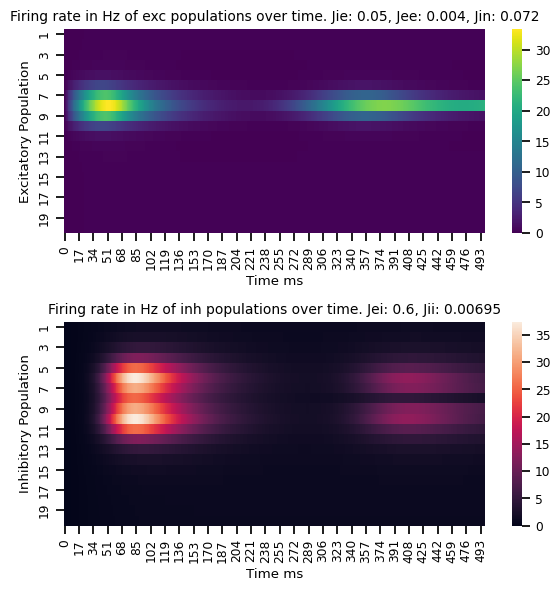

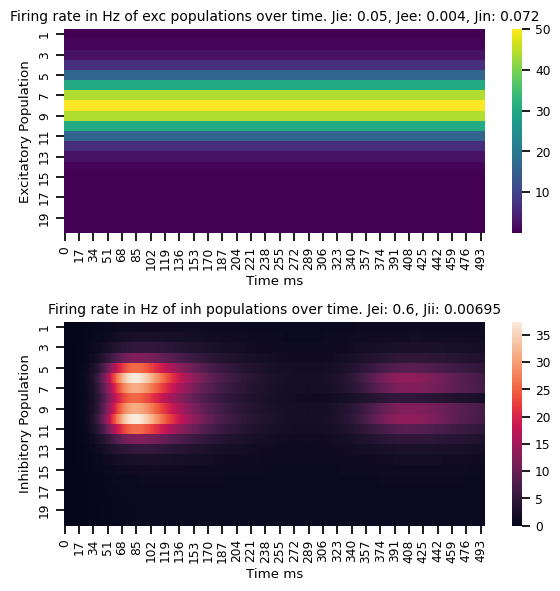

In [7]:
"""
*
*  Creat IN and Forward pass
*
*
"""


    ## Parameters used to create In
N = 20
# \\\\\\\\\\\ Parameters
param = Parameter(N=20, sIn=.1, sOut=3., sEI=.2)
# \\\\\\\\\\\ Simulation time
simu = Simulation(1e-4, .051)  # dt #rangeSim #dur = 2s

# \\\\\\\\\\\ Bottom up sensory input
stimuli = Stim(param, simu, dur=.050, f=[8], ISI=0) #dur = .050 #dur=.3 ,ISI=.05    # dur = 1s Isi=1s  #dur =.2
ic(simu.dt)
In2, range_sim, w, sigmaIn = stimuli.sensoryInput(param, simu, sigmaIn=2.) #2.
ic(In2.shape)
#J1 = {'Jee': 0.072, 'Jei': 0.004, 'Jie': 0.05, 'Jii': 0.6, 'Jin': 0.00695}
J1 = {'Jee': 0.072, 'Jei': 0.004, 'Jie': 0.05, 'Jii': 0.6, 'Jin': 0.00695}
J_list = list(J1.keys())

# +++++++++++++++++++++++++ Initialize the Model ++++++++++++++++++++++++++++
mymodel = MyModel_time()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sti = torch.tensor(stimuli.In, dtype=torch.float32)
r_e, r_i, dredt, dridt = mymodel.forward(sti)
ic(r_e.shape)
#print(torch.max(r_e[599,:]))
HeatMap(r_e.detach().numpy(), r_i.detach().numpy(), J1)
HeatMap(sti.detach().numpy(), r_i.detach().numpy(), J1)

''

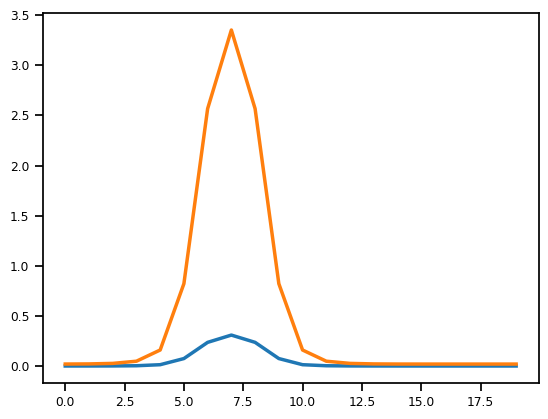

In [8]:
# cell to delete !!!!!!!!!!!!!
"""def make_it_proba(r_e):

    baseline = 1 #1
    sum_r_e_and_baseline = torch.sum(r_e, 1).reshape(r_e.shape[0], 1) + baseline
    prob_r = torch.div(r_e + baseline, sum_r_e_and_baseline)

    #I add this because when re = 0 proba becomes one everywhere. Alright?
    for i in range(r_e.shape[0]):
        if torch.sum(r_e[i,:]) == 0:
            prob_r[i,:] = 0
        else:
            prob_r = prob_r
    return prob_r.reshape(r_e.shape[0], r_e.shape[1]) 


r_e.shape[0]
#print(r_e.reshape(r_e.shape[1], r_e.shape[0]))
#ic(r_e.reshape(r_e.shape[0], r_e.shape[1]) )
#eps = 0.0001
eps = torch.FloatTensor([0.002])
r_e_max = torch.max(r_e, eps.expand_as(r_e))
threshold = 5# torch.FloatTensor([5]).expand_as(r_e[10,:])
sum_r_e = torch.sum(r_e, 1).reshape(r_e.shape[0], 1)
print(r_e.sum(0).shape)

prob_r= 0.5 * (1 + torch.tanh(sum_r_e - threshold))*(r_e_max / sum_r_e) #r_e_max.sum())
print(prob_r.shape)"""

def make_it_proba(r_e):

    eps = torch.FloatTensor([0.002])
    r_e_max = torch.max(r_e, eps.expand_as(r_e))
    threshold = 5# torch.FloatTensor([5]).expand_as(r_e[10,:])
    sum_r_e = torch.sum(r_e, 1).reshape(r_e.shape[0], 1)
    sum_max = torch.max(sum_r_e, eps)
    prob_r= 0.5 * (1 + torch.tanh(sum_r_e - threshold))*(r_e_max / sum_max) #r_e_max.sum())

    return prob_r #.reshape(r_e.shape[0], r_e.shape[1]) 

prob_r = make_it_proba(r_e)

plt.plot(np.arange(0,20), prob_r[3,:].detach().numpy())
plt.plot(np.arange(0,20), r_e[3,:].detach().numpy())
""""""

# Create Batch

## Data Preparation:

### 1- create a big dataset for every stimuli . Get prediction and X stimulus

In [9]:
stimu_dur = int(stimuli.dur /simu.dt)-1 
#sti2 = int(stimuli.dur *1000)-1
print(stimu_dur)

499


In [10]:
RE = torch.zeros(stimu_dur, 20 ,20)
RI = torch.zeros(stimu_dur, 20 ,20)
IN_T = torch.zeros(stimu_dur, 20 ,20)


param = Parameter(N=20, sIn=.1, sOut=3., sEI=.2)
# \\\\\\\\\\\ Simulation time
simu = Simulation(1e-4, .051)  # dt #rangeSim #dur = 2s


print(RE.shape)
print(In2.shape)
for i in range(param.N):
  # \\\\\\\\\\\ Bottom up sensory input
  st = Stim(param,simu, dur=.05,f =[i], ISI=0) #dur = 1s Isi=1s #dur=.2 = 200ms Isi = 0.1
  In, range_sim, w, sigmaIn =st.sensoryInput(param, simu, sigmaIn = 2.)
  IN_T[:,:, i] = torch.tensor(In)
  sti = torch.tensor(In).float()
  #RE[:,:,i], RI[:,:,i], dr_e_dt, dr_i_dt = mymodel.forward(sti) #s_ampa, s_gaba, i_tot_e, i_tot_i, In,


torch.Size([499, 20, 20])
(499, 20)


### 2- Split X into train and test dataset

Split 70% into train dataset and 30% into test dataset

In [11]:
rng = np.random.default_rng(1245)
dataset_size = (IN_T).shape[2]
rand_indices = rng.integers(low=0, high= (dataset_size-1), size=19)
#print(rng.shuffle(dataset_indices))

val_split_index = int(np.floor(0.7 * dataset_size))

test_idx, train_idx = rand_indices[val_split_index:], rand_indices[:val_split_index]



In [12]:
batch_training_size = (train_idx.shape)[0]

In [13]:
rng = np.random.default_rng(1245)
dataset_size = (RE).shape[2]
rand_indices = rng.integers(low=0, high= (dataset_size-1), size=19)
#print(rng.shuffle(dataset_indices))

val_split_index = int(np.floor(0.7 * dataset_size))

test_idx, train_idx = rand_indices[val_split_index:], rand_indices[:val_split_index]


train_tensorIN = IN_T[:,:, train_idx]
test_tensorIN = IN_T[:,:, test_idx]
train_tensorRE = RE[:,:, train_idx]
test_tensorRE = RE[:,:, test_idx]
train_tensorRI = RI[:,:, train_idx]
test_tensorRI = RI[:,:, test_idx]

#### 3- get expected Y - Ytarget

In [14]:
Xtrain_tensor = train_tensorIN.permute(2,0,1)#.shape
Ytrain_tensor = torch.zeros((Xtrain_tensor.shape))#, requires_grad = True)

for stimu in range(Xtrain_tensor.shape[0]):
  Ytrain_tensor[stimu,:,:] = get_expected_Y_relu(Xtrain_tensor[stimu,:,:])

### 4- Create the DataLoader merging Xtrain_tensor and Ytrain_tensor (Input and Target)

In [15]:
## 3- Create the DataLoader merging Xtrain_tensor and Ytrain_tensor
train_dataset = TensorDataset(Xtrain_tensor, Ytrain_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle = True) #one sample per batch

ic| X_input_proba.shape[1]: 20


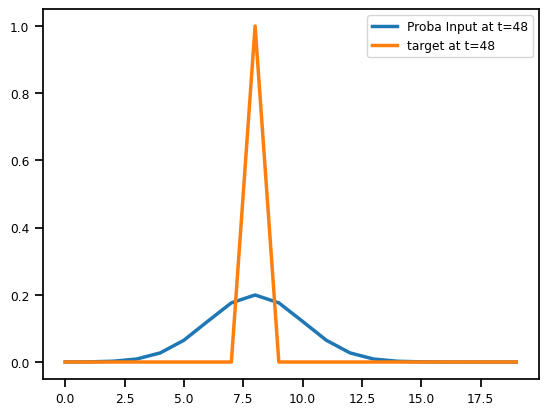

In [16]:
# 4- control what i have instide my tensors
X_input_proba = make_it_proba(Xtrain_tensor[2,:,:])
Y_target = Ytrain_tensor[2,:,:]
t=48
ic(X_input_proba.shape[1])
plt.plot(torch.arange(X_input_proba.shape[1]), X_input_proba[t,:], label= f"Proba Input at t={t}") #not in proba
plt.plot(torch.arange(Y_target.detach().numpy().shape[1]), Y_target.detach().numpy()[t,:], label = f"target at t={t}") #in proba
plt.legend()

# Optimization part

### Space for Loss design

In [44]:
def custom_loss_(re, Target, derivativeE, derivativeI):
  Cost = torch.tensor(0.0)
  
  #1/ Proba term
  Pred = make_it_proba(re)
  loss_proba = torch.zeros((Pred.shape))
  #loss_proba = torch.zeros((Pred.shape[0]))
  loss_inuse = torch.nn.NLLLoss()
  for t in range(re.shape[0]):
    target_pop_long = Target.select(0,t).long() #[t,:], dtype = torch.long)
    log_pred_pop = torch.log(Pred.select(0,t)) #(Pred.select(0,t))#torch.log # Pred.select(0,t) # change with Alex instead of: torch.log(Pred.select(0,t))#input = log(probability)
    # Calculate loss by comparing the distribution to the expected probabilities
    loss_proba[t,:] = loss_inuse(log_pred_pop, target_pop_long)#, reduction='none')  #negative log likelihood # why reduction = none??? #F.nll_loss
    
    #loss_proba[t] = F.nll_loss(log_pred_pop, target_pop_long)

  ### Sum over time step
  total_loss_proba = torch.sum(loss_proba)
  #ic(total_loss_proba)
  
  #2/ derivative good 
  stimu_pop= torch.argmax(Target).item()
  ### for excitatory neurons # targe = -derivative other ?
  #tensor_for_cost_derivative_E = derivativeE.clone() # torch.zeros((r_e.shape))
  #tensor_for_cost_derivative_E[:,stimu_pop] = - derivativeE.select(1, stimu_pop) #we want it to be negative for the stimulated population
  derivativeE[:,stimu_pop] = - derivativeE.select(1, stimu_pop) #we want it to be negative for the stimulated population
  #ic(tensor_for_cost_derivative_E.grad_fn)

  loss_derivative = - F.softplus(derivativeE[stimu_pop,:] ).mean() + F.softplus(derivativeE[:stimu_pop, :]).mean() + F.softplus(derivativeE[(stimu_pop+1):, :]).mean()

  #ic(loss_derivative)
  ### for inhibitory neurons
  """tensor_for_cost_derivative_I = derivativeI.clone() # torch.zeros((r_e.shape))
  tensor_for_cost_derivative_I = - derivativeI
  tensor_for_cost_derivative_I[:, stimu_pop] = derivativeI.select(1, stimu_pop) #[:,stimu_pop]) #tensor_for_cost_derivativeI = [i for i in derivativeI if i not in target_arr]

   """ """loss_derivative = torch.add(torch.sum(torch.mean(F.softplus(tensor_for_cost_derivative_E)**2, axis = 1)), #mean over popululation #then sum over every time step
                              torch.sum(torch.mean(F.softplus(tensor_for_cost_derivative_I)**2, axis = 1)))"""
  #mean instead of sum over time step
  #loss_derivative = torch.mean(torch.mean(F.softplus(tensor_for_cost_derivative_E)**2, axis = 1)) + torch.mean(torch.mean(F.softplus(tensor_for_cost_derivative_I)**2, axis = 1)) #mean over popululation #then sum over every time step
  
  #3/ L2 regu term
  l2_reg_coef=0.0001
  l2_reg = 0.0
  for param in mymodel.parameters():
      l2_reg += torch.sum(param**2)
  
  #4/ High value of re term
  # I have to change that !! firing rate still decreased after loss
  high_activity_penalty_coef=0.0001
  ic(torch.max(re[:,stimu_pop]))

  if torch.max(re[:,stimu_pop]) > 50: #60
     high_activity_penalty = torch.sum(torch.sum(re[:, stimu_pop]**2)) #torch.clamp(r_e[:, 7], max=10.0
  else:
     high_activity_penalty = 0
    
  #Cost = loss_derivative + total_loss_proba   
  L2_term = l2_reg * l2_reg_coef
  activity_regularization = high_activity_penalty * high_activity_penalty_coef
  Cost_f = loss_derivative + (total_loss_proba) + activity_regularization + L2_term #Cost_f+ 
  #ic(type(Cost_f))
  return Cost_f


In [18]:
tensor_for_cost_derivative_I = dridt.clone() # torch.zeros((r_e.shape))
tensor_for_cost_derivative_I = - dridt
tensor_for_cost_derivative_I[:, 8] = dridt.select(1, 8) #[:,stimu_pop]) #tensor_for_cost_derivativeI = [i for i in derivativeI if i not in target_arr]


print(tensor_for_cost_derivative_I[:,2])

tensor([-0.0000e+00, -2.0305e+02, -1.9996e+02, -1.9784e+02, -1.9664e+02,
        -1.9631e+02, -1.9681e+02, -1.9811e+02, -2.0019e+02, -2.0304e+02,
        -2.0666e+02, -2.1104e+02, -2.1617e+02, -2.2208e+02, -2.2875e+02,
        -2.3621e+02, -2.4446e+02, -2.5352e+02, -2.6340e+02, -2.7412e+02,
        -2.8569e+02, -2.9814e+02, -3.1146e+02, -3.2568e+02, -3.4082e+02,
        -3.5687e+02, -3.7385e+02, -3.9176e+02, -4.1060e+02, -4.3037e+02,
        -4.5106e+02, -4.7265e+02, -4.9512e+02, -5.1843e+02, -5.4255e+02,
        -5.6743e+02, -5.9301e+02, -6.1920e+02, -6.4594e+02, -6.7311e+02,
        -7.0061e+02, -7.2831e+02, -7.5605e+02, -7.8368e+02, -8.1102e+02,
        -8.3789e+02, -8.6407e+02, -8.8935e+02, -9.1350e+02, -9.3628e+02,
        -9.5745e+02, -9.7678e+02, -9.9402e+02, -1.0090e+03, -1.0214e+03,
        -1.0310e+03, -1.0378e+03, -1.0416e+03, -1.0422e+03, -1.0396e+03,
        -1.0337e+03, -1.0246e+03, -1.0122e+03, -9.9672e+02, -9.7820e+02,
        -9.5678e+02, -9.3266e+02, -9.0601e+02, -8.7

### Optimization for batch

In [37]:
def easyLoss(Y_pred_prob,target):
    #loss = torch.sum(torch.sum((Y_prediction_prob-Y_target), axis =1))
    #print(Y_pred_prob.max())
    return torch.mean((Y_pred_prob - target)**2)

In [50]:
def optimizerloop_BIG(model, train_dataloader, loss_f, Opt_name,learningRate, num_epoch):
  losses = torch.zeros(num_epoch) # used to plot the loss at the end
  
  for epoch in range(num_epoch):
    
    if Opt_name == "SGD":
        optimizer = optim.SGD(model.parameters(),
                      lr=learningRate, weight_decay = 0.0001)#, weight_decay = 0.00001) #, weight_decay = 0.00001)#, weight_decay = 0.001)#0.989
    elif Opt_name == "Adam":
        optimizer = optim.Adam(model.parameters(),
                      lr=learningRate)#, weight_decay = 0.00001) #, weight_decay = 0.00001)#, weight_decay = 0.001)#0.989
        

    model.train()

    for j,(x_train,y_train) in enumerate(train_dataloader):
      #print(y_train[0].shape)
      #print(x_train[0])
      
      # Clear the gradients
      optimizer.zero_grad()

      #calculate output
      Y_prediction, I, dredt, dridt = model(x_train[0])
      ic(Y_prediction.max())
      #calculate loss
      #loss =  loss_f(Y_prediction, y_train[0], dredt, dridt)
      #loss =  loss_f(Y_prediction, y_train[0])
      Y_prediction_prob = make_it_proba(Y_prediction)
      if loss_f == "easyLoss":
        loss = easyLoss(Y_prediction_prob, y_train[0])
      
      elif loss_f == "custom_loss_":
        loss = custom_loss_(Y_prediction, y_train[0], dredt, dridt)

      
      #accuracy
      #predicted = model(torch.tensor(x_train[0],dtype=torch.float32))
      
      acc = (Y_prediction_prob.detach().round() == y_train[0]).float().mean() #.reshape(-1)

      #backprop
      loss.backward()
      optimizer.step()
    losses[epoch] = loss
    print(f'Epoch [{epoch + 1}/{num_epoch}], Loss: {loss}')#.item()
    #print("total_loss.grad: ",loss.grad_fn, "x_train.grad", x_train[0].grad_fn,"y_train.grad", y_train[0].grad_fn)
    for par in mymodel.parameters():
      print(par.grad)

  return list(model.parameters()), losses, acc,optimizer

### Inputs and Labels

In [51]:
# +++++++++++++++++++++++++ Inputs + Labels +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
X_input = sti
#Y_prediction_prob =
Y_target = get_expected_Y_relu(X_input) #get the expected dirac delta for our particular Input

#print(custom_loss_(r_e, Y_target, dredt, dridt))

tensor([ 6.4039,  6.3860,  6.3703,  6.3941,  6.6594, 10.3669, 26.6985, 35.9198,
        26.6966, 10.3654,  6.6579,  6.3922,  6.3674,  6.3820,  6.3989,  6.4103,
         6.4167,  6.4202,  6.4224,  6.4242], grad_fn=<LogsumexpBackward0>)


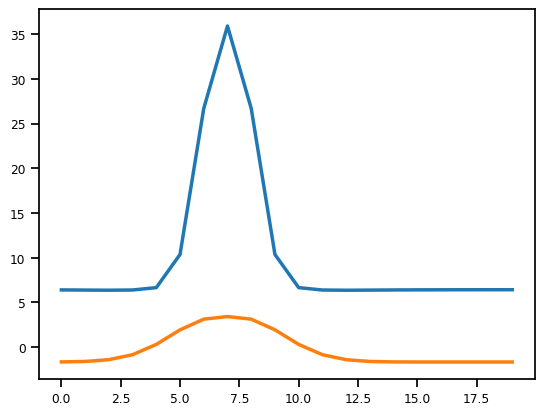

In [47]:
x = torch.tensor([1000.0, 1000.0])
log_prob_unstable = torch.log(torch.exp(x).sum())
t = 40
# Using torch.logsumexp for numerical stability
log_prob_stable = torch.logsumexp(r_e, dim=0)
log_prob = torch.log(r_e.select(0,t)) # r_e.select(0, 40).long()
print(log_prob_stable)
plt.plot(np.arange(0,20), log_prob_stable.detach().numpy())
plt.plot(np.arange(0,20), log_prob.detach().numpy())

In [23]:
#replace x input by max value of re just for investigation
#X_input.where(X_input ==1, torch.max(r_e, 1))

### Run 

In [52]:
#SGD + Mean Loss
num_epochs = 20
#lr = .0000001
lr = .001

#param_new, losses_list,optimizer = optimizerloop(mymodel, X_input, Y_target, custom_loss_, "Adam",lr, num_epochs) # easyLoss #custom_loss_
#param_new, losses_list,optimizer = optimizerloop(mymodel, X_input, Y_target, custom_loss_, "Adam",lr, num_epochs) # easyLoss #custom_loss_

#param_new, losses_list, accuracy,optimizer_trained = optimizerloop_BIG(mymodel, train_dataloader, "easyLoss", "Adam",lr, num_epochs) # easyLoss
param_new, losses_list, accuracy,optimizer_trained = optimizerloop_BIG(mymodel, train_dataloader, "custom_loss_", "Adam",lr, num_epochs) # easyLoss


ic| Y_prediction.max(): tensor(73.9677, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.8694, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(45.2647, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.7883, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(9.6128, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.3418, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(4.1157, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.2207, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.7679, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1520, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.7634, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.0909, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.3526, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.0513, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.3264, grad_fn=<MaxBackward1

Epoch [1/20], Loss: 35388.1136466381
tensor(-82.7809, dtype=torch.float64)
tensor(4603.7228, dtype=torch.float64)
tensor(64343.8655, dtype=torch.float64)
tensor(-32.5891, dtype=torch.float64)
tensor(-821223.1904, dtype=torch.float64)


ic| Y_prediction.max(): tensor(0.4744, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.0659, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.1660, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1175, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.8815, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1535, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(2.2147, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1723, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(2.0960, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1689, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(2.1403, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1675, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.9533, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1621, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.5973, grad_fn=<MaxBackward1>)

Epoch [2/20], Loss: 36343.430049038696
tensor(-178.5186, dtype=torch.float64)
tensor(84317.5443, dtype=torch.float64)
tensor(254279.8567, dtype=torch.float64)
tensor(-419.8900, dtype=torch.float64)
tensor(-3100827.1767, dtype=torch.float64)


ic| Y_prediction.max(): tensor(0.3360, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.0497, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.8165, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1006, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.2703, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1342, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.3817, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1388, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.2734, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1395, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.6422, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1523, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.8821, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1642, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.9309, grad_fn=<MaxBackward1>)

Epoch [3/20], Loss: 35407.965204326356
tensor(-14.1277, dtype=torch.float64)
tensor(-42633.2059, dtype=torch.float64)
tensor(-15345.9905, dtype=torch.float64)
tensor(181.5849, dtype=torch.float64)
tensor(589980.5042, dtype=torch.float64)


ic| Y_prediction.max(): tensor(0.8131, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1077, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.8611, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1718, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(3.3392, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.2208, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(4.3327, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.2651, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(5.1081, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.3093, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(5.4480, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.3305, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(5.3681, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.3254, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(5.0504, grad_fn=<MaxBackward1>)

Epoch [4/20], Loss: 35407.449576574254
tensor(-21.9478, dtype=torch.float64)
tensor(-21834.5000, dtype=torch.float64)
tensor(30246.7419, dtype=torch.float64)
tensor(52.5274, dtype=torch.float64)
tensor(359723.6289, dtype=torch.float64)


ic| Y_prediction.max(): tensor(1.0715, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1271, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(2.4166, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1967, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.5100, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1534, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.9146, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1129, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.6226, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.0881, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.8773, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1102, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.1796, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1328, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.4237, grad_fn=<MaxBackward1>)

Epoch [5/20], Loss: 35745.62535829199
tensor(0.4165, dtype=torch.float64)
tensor(-87056.0085, dtype=torch.float64)
tensor(-96700.5556, dtype=torch.float64)
tensor(692.1299, dtype=torch.float64)
tensor(771279.1514, dtype=torch.float64)


ic| Y_prediction.max(): tensor(2.0587, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1807, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.9101, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1133, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.7763, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1017, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.0910, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1272, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.2831, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1399, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.2916, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1402, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.1514, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1310, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.9086, grad_fn=<MaxBackward1>)

Epoch [6/20], Loss: 36101.28942207704
tensor(27.3426, dtype=torch.float64)
tensor(-43780.3699, dtype=torch.float64)
tensor(-45919.3241, dtype=torch.float64)
tensor(513.7544, dtype=torch.float64)
tensor(1221248.2308, dtype=torch.float64)


ic| Y_prediction.max(): tensor(4.3901, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.2860, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(2.0642, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1835, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.9768, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1190, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.5621, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.0800, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.8034, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1034, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.1013, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1269, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.5112, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1605, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(2.1315, grad_fn=<MaxBackward1>)

Epoch [7/20], Loss: 36220.21910918418
tensor(32.2136, dtype=torch.float64)
tensor(-50089.8273, dtype=torch.float64)
tensor(-99284.0410, dtype=torch.float64)
tensor(785.1728, dtype=torch.float64)
tensor(1149164.3698, dtype=torch.float64)


ic| Y_prediction.max(): tensor(4.0762, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.3140, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.8648, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1735, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.8887, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1115, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.2850, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1397, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.5971, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1584, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.7177, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1648, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.7107, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1647, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.5831, grad_fn=<MaxBackward1>)

Epoch [8/20], Loss: 34988.99645189854
tensor(-77.1629, dtype=torch.float64)
tensor(42544.6103, dtype=torch.float64)
tensor(222955.0128, dtype=torch.float64)
tensor(-577.8675, dtype=torch.float64)
tensor(-723284.9020, dtype=torch.float64)


ic| Y_prediction.max(): tensor(1.0468, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1254, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(2.3059, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1949, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.4875, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1543, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.8226, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1067, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.6292, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.0887, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.8949, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1116, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.3118, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1437, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.8937, grad_fn=<MaxBackward1>)

Epoch [9/20], Loss: 35736.40270273936
tensor(16.3525, dtype=torch.float64)
tensor(-14648.4575, dtype=torch.float64)
tensor(17509.7578, dtype=torch.float64)
tensor(235.3039, dtype=torch.float64)
tensor(1213719.6735, dtype=torch.float64)


ic| Y_prediction.max(): tensor(3.2169, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.2321, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.5657, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1588, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.7423, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.0984, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.6204, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.0859, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.9095, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1125, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.2828, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1395, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.6397, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1606, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.9259, grad_fn=<MaxBackward1>)

Epoch [10/20], Loss: 35052.70348419942
tensor(-11.8015, dtype=torch.float64)
tensor(-31637.7162, dtype=torch.float64)
tensor(-67541.8328, dtype=torch.float64)
tensor(486.3840, dtype=torch.float64)
tensor(601060.1304, dtype=torch.float64)


ic| Y_prediction.max(): tensor(1.8358, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1788, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.8292, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1067, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.0698, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1295, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.7576, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1695, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(2.4028, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1955, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(2.6262, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.2040, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(2.6429, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.2056, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(2.5036, grad_fn=<MaxBackward1>)

Epoch [11/20], Loss: 35149.46910832449
tensor(-82.5324, dtype=torch.float64)
tensor(82480.0970, dtype=torch.float64)
tensor(430269.1595, dtype=torch.float64)
tensor(-1387.8085, dtype=torch.float64)
tensor(-633401.0878, dtype=torch.float64)


ic| Y_prediction.max(): tensor(0.9767, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1214, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(2.1317, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1897, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.5589, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1617, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.5486, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1574, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.2928, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1408, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.9640, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1163, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.6909, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.0938, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.9503, grad_fn=<MaxBackward1>)

Epoch [12/20], Loss: 34892.44176652908
tensor(-20.8566, dtype=torch.float64)
tensor(-23390.9014, dtype=torch.float64)
tensor(-43536.9450, dtype=torch.float64)
tensor(383.2843, dtype=torch.float64)
tensor(625160.4899, dtype=torch.float64)


ic| Y_prediction.max(): tensor(1.7745, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1722, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.8216, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1059, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.8429, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1065, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.9106, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1148, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.3736, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1444, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.9249, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1784, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(2.4966, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.2007, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(2.9255, grad_fn=<MaxBackward1>)

Epoch [13/20], Loss: 34969.519891976655
tensor(-37.6623, dtype=torch.float64)
tensor(45344.6490, dtype=torch.float64)
tensor(345409.7135, dtype=torch.float64)
tensor(-1046.5332, dtype=torch.float64)
tensor(537917.6230, dtype=torch.float64)


ic| Y_prediction.max(): tensor(1.2499, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1439, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(2.6942, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.2165, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.5717, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1623, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.8584, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1108, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.8427, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1091, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.1355, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1369, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.6715, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1654, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(2.3691, grad_fn=<MaxBackward1>)

Epoch [14/20], Loss: 34724.15270558126
tensor(-21.8777, dtype=torch.float64)
tensor(-31882.1461, dtype=torch.float64)
tensor(-154581.5519, dtype=torch.float64)
tensor(637.1871, dtype=torch.float64)
tensor(502798.5770, dtype=torch.float64)


ic| Y_prediction.max(): tensor(1.2705, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1421, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.5788, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.0809, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.6956, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.0922, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.1914, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1325, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.5628, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1542, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.7692, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1665, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.9041, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1847, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(2.2452, grad_fn=<MaxBackward1>)

Epoch [15/20], Loss: 35275.148799396455
tensor(-21.2254, dtype=torch.float64)
tensor(77352.2466, dtype=torch.float64)
tensor(551501.3137, dtype=torch.float64)
tensor(-1883.4146, dtype=torch.float64)
tensor(958531.5923, dtype=torch.float64)


ic| Y_prediction.max(): tensor(1.5538, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1632, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.7493, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1007, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.0659, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1271, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.4724, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1536, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.5900, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1595, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.2101, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1351, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.8897, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1109, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.9895, grad_fn=<MaxBackward1>)

Epoch [16/20], Loss: 25711.090208134978
tensor(-140.6825, dtype=torch.float64)
tensor(26759.4419, dtype=torch.float64)
tensor(216121.1563, dtype=torch.float64)
tensor(-381.1063, dtype=torch.float64)
tensor(-6169735.2060, dtype=torch.float64)


ic| Y_prediction.max(): tensor(1.2152, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1401, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(2.5803, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.2057, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(2.9165, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.2179, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(2.4757, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.2038, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.8289, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1763, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.2846, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1445, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.8488, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1105, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.6480, grad_fn=<MaxBackward1>)

Epoch [17/20], Loss: 35921.14880372114
tensor(26.7990, dtype=torch.float64)
tensor(-54150.7814, dtype=torch.float64)
tensor(-552977.5744, dtype=torch.float64)
tensor(1363.3426, dtype=torch.float64)
tensor(1173632.3307, dtype=torch.float64)


ic| Y_prediction.max(): tensor(2.8912, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.2144, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.3115, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1442, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.6652, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.0911, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.6659, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.0915, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.9131, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1154, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.3127, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1452, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.6838, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1675, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.9233, grad_fn=<MaxBackward1>)

Epoch [18/20], Loss: 34672.586304123826
tensor(-28.4130, dtype=torch.float64)
tensor(-22354.7814, dtype=torch.float64)
tensor(-112093.5560, dtype=torch.float64)
tensor(429.2402, dtype=torch.float64)
tensor(264099.0266, dtype=torch.float64)


ic| Y_prediction.max(): tensor(1.3397, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1481, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(2.8586, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.2138, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(2.6913, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.2097, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.9886, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1829, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.3494, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1487, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.9474, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1191, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.8089, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1073, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.9053, grad_fn=<MaxBackward1>)

Epoch [19/20], Loss: 35243.77771043455
tensor(2.6957, dtype=torch.float64)
tensor(-41539.7594, dtype=torch.float64)
tensor(-336784.1219, dtype=torch.float64)
tensor(1088.9585, dtype=torch.float64)
tensor(960081.6446, dtype=torch.float64)


ic| Y_prediction.max(): tensor(2.3787, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1991, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.1002, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1310, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(0.7145, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.0974, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.1062, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1325, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.5428, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1600, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.7899, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1729, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.9346, grad_fn=<MaxBackward1>)
ic| torch.max(re[:,stimu_pop]): tensor(0.1796, grad_fn=<MaxBackward1>)
ic| Y_prediction.max(): tensor(1.9484, grad_fn=<MaxBackward1>)

Epoch [20/20], Loss: 34861.35193016513
tensor(-18.8975, dtype=torch.float64)
tensor(20324.9978, dtype=torch.float64)
tensor(246056.4844, dtype=torch.float64)
tensor(-570.4514, dtype=torch.float64)
tensor(845105.8076, dtype=torch.float64)


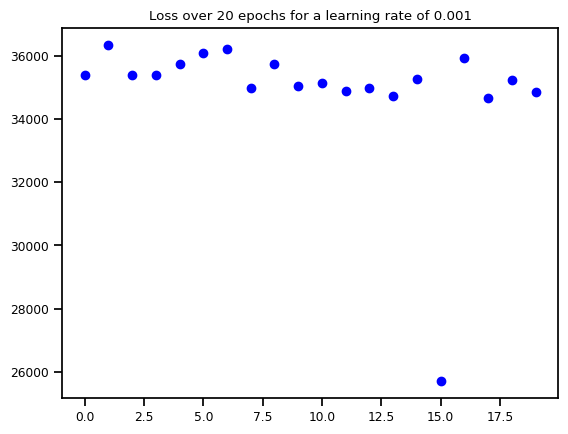

In [53]:
plt.plot(np.arange(losses_list.shape[0]), losses_list.detach().numpy(), 'bo', label='Training loss')
plt.title(f"Loss over {num_epochs} epochs for a learning rate of {lr}")
plt.show()

# Save trained parameters and use them in a new model

In [87]:
print(batch_training_size)

14


In [88]:

Xtrain_tensor.shape

torch.Size([14, 49, 20])

old model Parameter containing:
tensor(1.3489, dtype=torch.float64, requires_grad=True) new model Parameter containing:
tensor(1.3489, dtype=torch.float64, requires_grad=True)


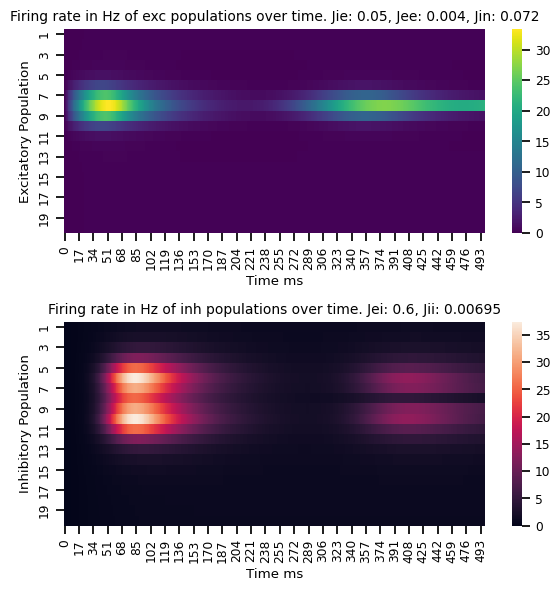

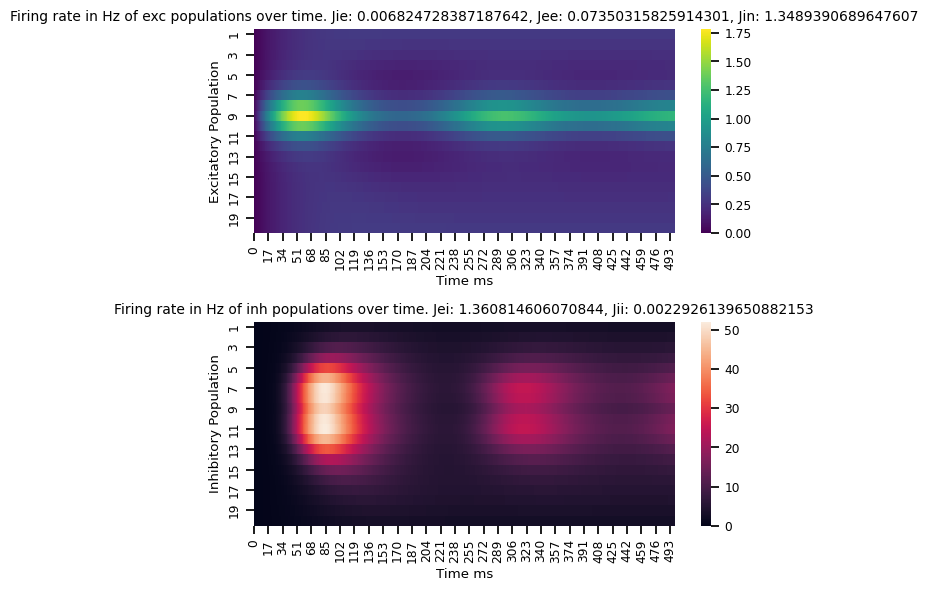

In [54]:
#Use a function which save parameters of trained model and upload the new model with the updated parameters


trained_model, optimizer_trained = model_with_saved_trained_param(mymodel, optimizer_trained, MyModel_time) #optimizer_trained

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RE_trained = torch.zeros(Xtrain_tensor.shape)
RI_trained = torch.zeros(Xtrain_tensor.shape)
dREdt_trained = torch.zeros(Xtrain_tensor.shape)
dRIdt_trained = torch.zeros(Xtrain_tensor.shape)

for batch in range(batch_training_size):
    RE_trained[batch,:,:], RI_trained[batch,:,:], dREdt_trained[batch,:,:], dRIdt_trained[batch,:,:] = trained_model.forward(Xtrain_tensor[batch,:,:]) #Xtrain_tensor[2,:,:]

#J1 = {'Jee': mymodel.Jee.detach().numpy(), 'Jei': mymodel.Jei.detach().numpy(), 'Jie': mymodel.Jie.detach().numpy(), 'Jii': mymodel.Jii.detach().numpy(), 'Jin': trained_model.Jin.detach().numpy()}
HeatMap(r_e.detach().numpy(), r_i.detach().numpy(), J1)

J2= {'Jee': trained_model.Jee.detach().numpy(), 'Jei': trained_model.Jei.detach().numpy(), 'Jie': trained_model.Jie.detach().numpy(), 'Jii': trained_model.Jii.detach().numpy(), 'Jin': trained_model.Jin.detach().numpy()}
HeatMap(RE_trained[2,:,:].detach().numpy(), RI_trained[2,:,:].detach().numpy(), J2)


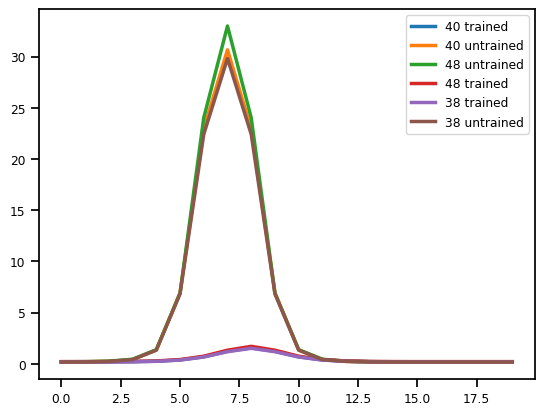

In [55]:
t = 40
t2 = 48
t3 = 38
r_e_trained = RE_trained[2,:,:]
retrained_t2 = r_e_trained[t2,:].detach().numpy()
plt.plot(np.arange(r_e_trained.shape[1]), r_e_trained[t,:].detach().numpy(), label = f"{t} trained")
#plt.plot(np.arange(r_e_trained.shape[1]), re_trained_norm_t2 = , label = f"{t2} trained")
plt.plot(np.arange(r_e_trained.shape[1]), r_e[t,:].detach().numpy(), label = f"{t} untrained")

plt.plot(np.arange(r_e_trained.shape[1]), r_e[t2,:].detach().numpy(), label = f"{t2} untrained")
plt.plot(np.arange(r_e_trained.shape[1]), r_e_trained[t2,:].detach().numpy(), label = f"{t2} trained")

plt.plot(np.arange(r_e_trained.shape[1]), r_e_trained[t3,:].detach().numpy(), label = f"{t3} trained")
plt.plot(np.arange(r_e_trained.shape[1]), r_e[t3,:].detach().numpy(), label = f"{t3} untrained")

#plt.plot(np.arange((r_e_bad[t,:].detach().numpy()).shape[0]), r_e_bad[t,:].detach().numpy(), label = f"bad {t}")
#plt.plot(np.arange((r_e_bad[t2,:].detach().numpy()).shape[0]), r_e_bad[t2,:].detach().numpy(), label = f"bad {t2}")

plt.legend()

# Do the test with new parameters

In [91]:
"""
*
*
***********  CLASS MYMODEL
*
*
"""


class BadParamModel(nn.Module):
    def __init__(self):
        super(BadParamModel, self).__init__()

        #--- Define other model parameters, layers, or components here if needed
        self.dt = torch.tensor(1e-4) #sim.dt
        self.N = 20
        self.taue = self.taui = torch.tensor(0.005)
         # ¤ parameter of the phi function Not tweakable parameters
        self.ae = torch.tensor(18.26)  # 2 #Wong have to check # Modelling and Meg Gain of the E populaiton
        self.be = torch.tensor(-5.38)  # Threshold of the E populaiton
        self.hme = torch.tensor(78.67)
        self.ai = torch.tensor(21.97)
        self.bi = torch.tensor(-4.81)
        self.hmi = torch.tensor(125.62)
        #create the smallest possible number
        self.epsilon = sys.float_info.epsilon

        self.sIn = torch.tensor(.1)
        self.sOut= 3.
        self.sEI = .2
        self.tauAMPA = torch.tensor(0.002)
        self.tauGABA = torch.tensor(0.005)

        self.wei = torch.tensor(dog_filter(self.sOut, int(self.N)), dtype=torch.float32)
        self.wii = torch.tensor(np.eye(int(self.N)), dtype=torch.float32) # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(self.sEI, int(self.N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(self.N)), dtype=torch.float32)  # Identity matrix


        # initial parameters
        self.Jee = nn.Parameter(torch.tensor(0.04, requires_grad= True, dtype= torch.float64))#, requires_grad=False, dtype=torch.float32)#I replaced .072 by 0.072
        #ic(self.Jee.grad_fn) #should be none
        self.Jei = nn.Parameter(torch.tensor(0.001, requires_grad= True, dtype= torch.float64))
        self.Jie = nn.Parameter(torch.tensor(0.01, requires_grad=True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(0.4, requires_grad=True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(0.00595, requires_grad= True, dtype=torch.float64))


    def phi(self, I_tot, a, b, hm): #)))  # this use a lot of memory - exponential part
        #multi= torch.nan_to_num((torch.mul(a, I_tot) + b), nan = self.epsilon, posinf=140, neginf=self.epsilon)

        for i in range(I_tot.shape[0]):
                if torch.isnan(I_tot[i])== True:
                    ic(I_tot, i)
                    quit()
                    sys.exit() #sys.

        mulan =torch.mul(a, I_tot)

        multi= mulan + b

        expo = torch.exp(- (multi))  #.abs()+ self.epsilon)
        return torch.multiply(hm, torch.divide(1, (1+ expo)))

    def forward(self, In):
        #--- Initialize model variables here
        prev_r_e = torch.zeros((In.shape[0], self.N)) # torch.ones(self.N) shows more obvious results
        prev_r_i = torch.zeros((In.shape[0], self.N))
        prev_s_ampa = torch.zeros((In.shape[0], self.N))
        prev_s_gaba = torch.zeros((In.shape[0], self.N))
        dr_e_dt = torch.zeros((In.shape[0], self.N))
        dr_i_dt = torch.zeros((In.shape[0], self.N))
        s_ampa = torch.tensor(0.)
        i_tot_e = torch.tensor(0.)
        i_tot_i = torch.tensor(0.)

        for k in range(1, In.shape[0]):
            #--- Compute values of interest
            #the operation Jee_re = self.Jee * prev_r_e => triggers inplace error
            s_gaba_wie = prev_s_gaba[k-1,:] @ self.wie
            s_ampa_wei = prev_s_ampa[k-1,:] @ self.wei
            s_gaba_wii = prev_s_gaba[k-1,:] @ self.wii
            JeeAmpa =  torch.mul(self.Jee, s_ampa)
            i_tot_e = torch.add(torch.subtract(JeeAmpa, torch.mul(self.Jie, s_gaba_wie)), torch.mul(self.Jin, In[k - 1, :]))
            i_tot_i = torch.subtract(torch.mul(self.Jei, s_ampa_wei), torch.mul(self.Jii, s_gaba_wii))

            phi_arr_e = self.phi(i_tot_e, self.ae, self.be, self.hme)
            phi_arr_i = self.phi(i_tot_i, self.ai, self.bi, self.hmi)

            dr_e_dt[k,:] = (-prev_r_e[k - 1, :] + phi_arr_e) / self.taue
            dr_i_dt[k,:] = (-prev_r_i[k - 1, :] + phi_arr_i) / self.taui

            r_e = prev_r_e[k - 1, :] + dr_e_dt[k,:] * self.dt
            r_i = prev_r_i[k - 1, :] + dr_i_dt[k,:] * self.dt

            dS_amp_dt = (- prev_s_ampa[k - 1, :] / self.tauAMPA) + r_e
            s_ampa = prev_s_ampa[k - 1, :] + dS_amp_dt * self.dt

            dS_gab_dt = (- prev_s_gaba[k - 1, :] / self.tauGABA) + r_i
            s_gaba = prev_s_gaba[k - 1, :] + dS_gab_dt * self.dt

            prev_r_e[k,:] = r_e
            prev_r_i[k,:] = r_i
            prev_s_ampa[k,:] = s_ampa
            prev_s_gaba[k,:] = s_gaba


        return prev_r_e, prev_r_i, dr_e_dt, dr_i_dt




tensor(10.4172, grad_fn=<MaxBackward1>)


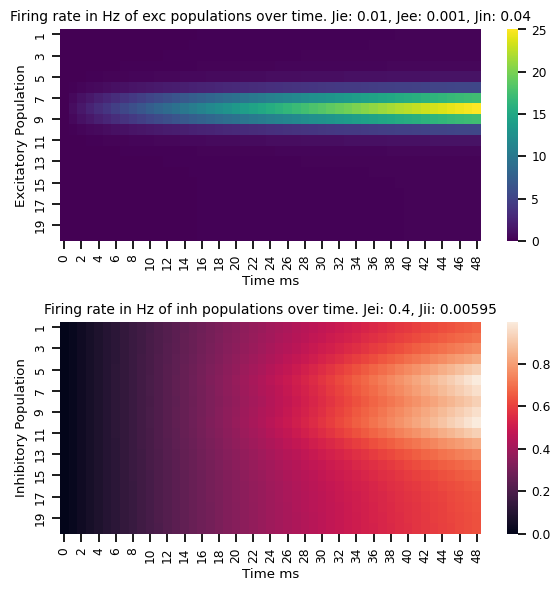

In [92]:
"""*
*  Forward pass for bad parameter
*
*
"""

# +++++++++++++++++++++++++ Initialize the Model ++++++++++++++++++++++++++++
mybadmodel = BadParamModel()
J_bad = {'Jee': mybadmodel.Jee.detach().numpy(), 'Jei': mybadmodel.Jei.detach().numpy(), 'Jie': mybadmodel.Jie.detach().numpy(), 'Jii': mybadmodel.Jii.detach().numpy()
      , 'Jin': mybadmodel.Jin.detach().numpy()}

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sti = torch.tensor(stimuli.In, dtype=torch.float32)
r_e_bad, r_i_bad, dredt_bad, dridt_bad = mybadmodel.forward(sti)
print(torch.max(r_e[10,:]))
HeatMap(r_e_bad.detach().numpy(), r_i_bad.detach().numpy(), J_bad)

In [93]:
#SGD + Mean Loss
num_epochs = 10
lr = .00001

#param_new, losses_list,optimizer = optimizerloop(mymodel, X_input, Y_target, custom_loss_, "Adam",lr, num_epochs) # easyLoss #custom_loss_
param_new, losses_list_bad, accuracy_bad, optimizer_trained_bad = optimizerloop_BIG(mybadmodel,train_dataloader , custom_loss_, "Adam",lr, num_epochs) # easyLoss #custom_loss_


UnboundLocalError: cannot access local variable 'loss' where it is not associated with a value

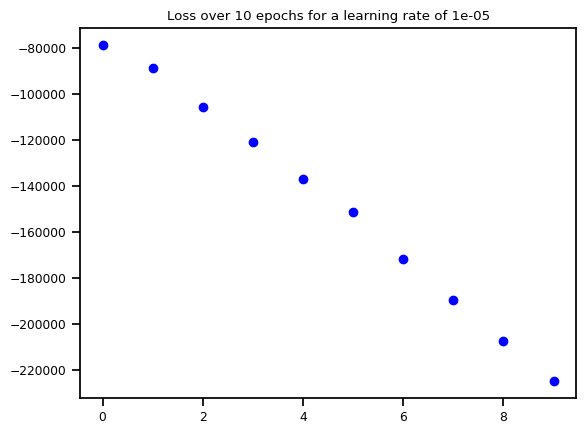

In [ ]:
plt.plot(np.arange(losses_list_bad.shape[0]), losses_list_bad.detach().numpy(), 'bo', label='Training loss')
plt.title(f"Loss over {num_epochs} epochs for a learning rate of {lr}")
plt.show()

old model Parameter containing:
tensor(0.0414, dtype=torch.float64, requires_grad=True) new model Parameter containing:
tensor(0.0414, dtype=torch.float64, requires_grad=True)


ic| torch.max(r_e_bad): tensor(36.3049, grad_fn=<MaxBackward1>)
ic| torch.max(r_e_bad_trained): tensor(63.1027, grad_fn=<MaxBackward1>)


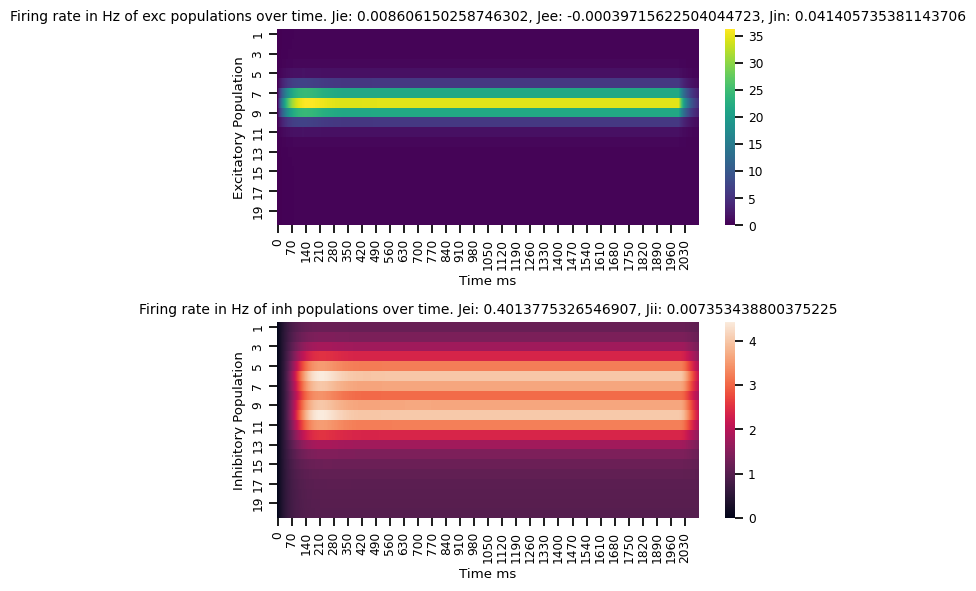

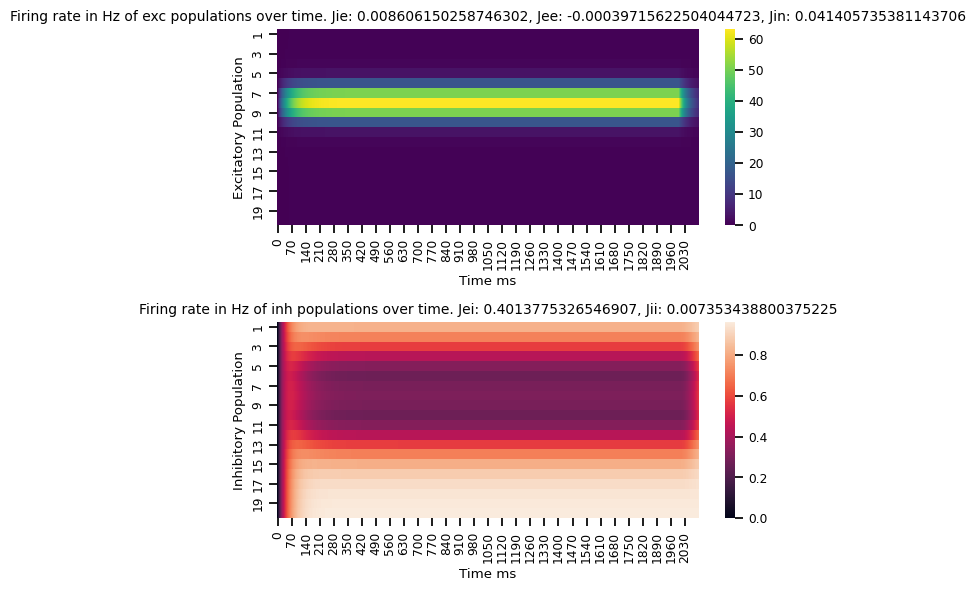

In [ ]:
trained_bad_model, optimizer_bad_trained = model_with_saved_trained_param(mybadmodel, optimizer_trained_bad, BadParamModel)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

r_e_bad_trained, r_i_bad_trained, dredt_bad_trained, dridt_bad_trained = trained_bad_model.forward(sti) #Xtrain_tensor[2,:,:]
ic(torch.max(r_e_bad))
ic(torch.max(r_e_bad_trained))

#J1 = {'Jee': mymodel.Jee.detach().numpy(), 'Jei': mymodel.Jei.detach().numpy(), 'Jie': mymodel.Jie.detach().numpy(), 'Jii': mymodel.Jii.detach().numpy(), 'Jin': trained_model.Jin.detach().numpy()}
HeatMap(r_e_bad.detach().numpy(), r_i_bad.detach().numpy(), J_bad)
J2= {'Jee': trained_bad_model.Jee.detach().numpy(), 'Jei': trained_bad_model.Jei.detach().numpy(), 'Jie': trained_bad_model.Jie.detach().numpy(), 'Jii': trained_bad_model.Jii.detach().numpy(), 'Jin': trained_bad_model.Jin.detach().numpy()}
HeatMap(r_e_bad_trained.detach().numpy(), r_i_bad_trained.detach().numpy(), J2)

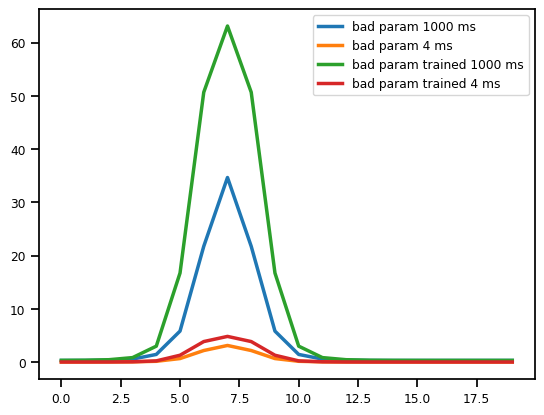

In [ ]:
t = 1000
t2= 4
#plt.plot(np.arange((r_e[t,:].detach().numpy()).shape[0]), r_e[t,:].detach().numpy(), label = f"time {t} ms")
#plt.plot(np.arange((r_e[t2,:].detach().numpy()).shape[0]), r_e[t2,:].detach().numpy(), label = f"time {t2} ms")
plt.plot(np.arange((r_e_bad[t,:].detach().numpy()).shape[0]), r_e_bad[t,:].detach().numpy(), label = f"bad param {t} ms")
plt.plot(np.arange((r_e_bad[t2,:].detach().numpy()).shape[0]), r_e_bad[t2,:].detach().numpy(), label = f"bad param {t2} ms")
plt.plot(np.arange((r_e_bad_trained[t,:].detach().numpy()).shape[0]), r_e_bad_trained[t,:].detach().numpy(), label = f"bad param trained {t} ms")
plt.plot(np.arange((r_e_bad_trained[t2,:].detach().numpy()).shape[0]), r_e_bad_trained[t2,:].detach().numpy(), label = f"bad param trained {t2} ms")
plt.legend()

